In [1]:
# from standard library
import json
import copy

# dependencias
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

load data off my site

In [2]:
#constants
DATA_URL = 'http://www.nicholdav.info/static/results_dict.json'
BIRD_NAMES_DICT = {
    'bird 1':'gr41rd51',
    'bird 2':'gy6or6',
    'bird 3':'or60yw70',
    'bird 4':'bl26lb16'
    }
BIRD_NAME_LIST = ['bird 1','bird 2','bird 3','bird 4']
NUM_SONGS_TO_TEST = list(range(3,16,3)) + [21,27,33,39]
# i.e., [3,6,9,...15,21,27,33,39].

with open('results_dict.json') as results_json:
    results_dict = json.load(results_json)

In [3]:
for key, subdict in results_dict.items():
    for key, val in subdict.items():
        subdict[key] = np.asarray(val)

### combine data across birds

To combine data across birds, I bin by number of samples. For previous results, the amount of training data for the algorithms was determined by "number of songs", but each song can have a different number of syllables, i.e., samples. Each bin contains a range of sample sizes, e.g. 150-300 samples.

In [4]:
these_keys = ['knn_test_avg_acc',
              'svm_Tach_test_avg_acc',
              'flatwindow_avg_acc',
             'num_train_samples']

# convert everything to np.ndarray
munged = {}
for key in these_keys:
    arr_list = []
    for bird, birddict in results_dict.items():
        arr_list.append(birddict[key])
    stacked = np.vstack(arr_list)
    munged[key] = stacked

In [5]:
bin_range = (range(0,6900,300))  # max number of samples is 6522, want bins 300 samples wide
bin_ranges = list(zip(bin_range[:-1],bin_range[1:]))
train_size_bin_centers = np.asarray(list(range(150,6600,300)))
these_keys = ['knn_test_avg_acc',
              'svm_Tach_test_avg_acc',
              'flatwindow_avg_acc']

binned_mats = {}
num_train_samples = munged['num_train_samples']
for key in these_keys:
    # make list of binned values--list because
    # can't know number of values per bin ahead of time
    binned_list = []
    for bin_ind, (bin_begin, bin_end) in enumerate(bin_ranges):
        # find where num train samples falls within bin
        these_inds = (bin_begin < num_train_samples) & (num_train_samples < bin_end)
        # get accuracies that correspond to those num train samples
        these_accs = munged[key][these_inds]
        binned_list.append(these_accs)

    arr_lengths = [arr.shape[-1] for arr in binned_list]
    height = np.max(arr_lengths)
    binned_with_nans = np.full((height,
                                train_size_bin_centers.shape[-1]),
                               np.nan)
    for ind, arr in enumerate(binned_list):
        length = arr.shape[-1]
        binned_with_nans[:length,ind] = arr 
    binned_mats[key] = binned_with_nans

### plot binned data to inspect visually

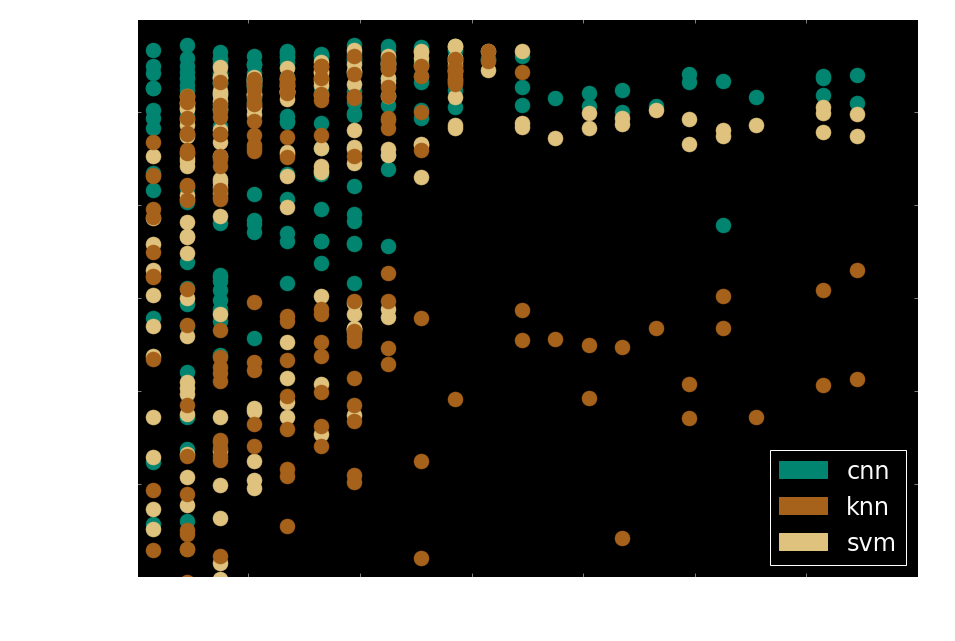

In [6]:
#plot lin-SVM, SVM-RBF, and k-NN all together on same graph
fig = plt.figure()
plt.style.use('dark_background')
fig.set_size_inches(14,10)

color_dict = {'knn': '#a6611a',
     'svm': '#dfc27d',
     'linear svm': '#80cdc1',
     'cnn': '#018571'}

ax=[]
plt.plot(train_size_bin_centers,
        binned_mats['flatwindow_avg_acc'].T,
        '.',
        label='cnn',
        markersize=30,
        color=color_dict['cnn'])
plt.plot(train_size_bin_centers,
        binned_mats['svm_Tach_test_avg_acc'].T,
        '.',
        label='svm',
        markersize=30,
        color=color_dict['svm'])
plt.plot(train_size_bin_centers,
        binned_mats['knn_test_avg_acc'].T,
        '.',
        label='knn',
        markersize=30,
        color=color_dict['knn'])

patchlist = [mpatches.Patch(color=val, label=key)
                   for key, val in color_dict.items()
                    if key != 'linear svm']

plt.legend(handles=patchlist,
                   fontsize=24,
                   loc='lower right')
plt.xlabel('no. training samples', fontsize = 24)
plt.ylabel('avg. acc.\nacross birds', fontsize = 24)
plt.tick_params(axis='both', which='major', labelsize=24)


plt.ylim([97,100])

plt.show()

Looks like there's a wide range in accuracies. Notice that there are less data points for accuracies at the higher end. In fact I think these are mainly from one bird who had a lot of repeats and higher numbers of syllables per song. Parameters from fitting this data might be very different if this bird were left out of the analysis--should examine futher.

### take median, fit curves

In [7]:
nanmeds = {}
for key in these_keys:
    nanmeds[key] = np.nanmedian(binned_mats[key],axis=0)

C:\Users\Seymour Snyder\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3858: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


define function to fit, exponential decay in the style of Sober Brainard 2012

In [8]:
def func(x, c, tau):
    return c*(1-np.exp(-x/tau))

In [10]:
fit_params = {}
for model, medians in nanmeds.items():
    not_nans = ~np.isnan(nanmeds[model])
    these_vals = nanmeds[model][not_nans]
    these_bins = train_size_bin_centers[not_nans]
    popt, pcov = curve_fit(func,
                           these_bins,
                           these_vals,
                           p0=(99.8,2000))
    fit_params[model] = {
        'popt':popt,
        'pcov':pcov}

Generate many points from the curve function using our fit parameters so we can plot the curve over the actual data points

In [11]:
xx = np.linspace(10, 6500, 3000)
fitlines = {}
for model, params in fit_params.items():
    yy = func(xx, *params['popt'])
    fitlines[model] = yy

Plot the actual graphs

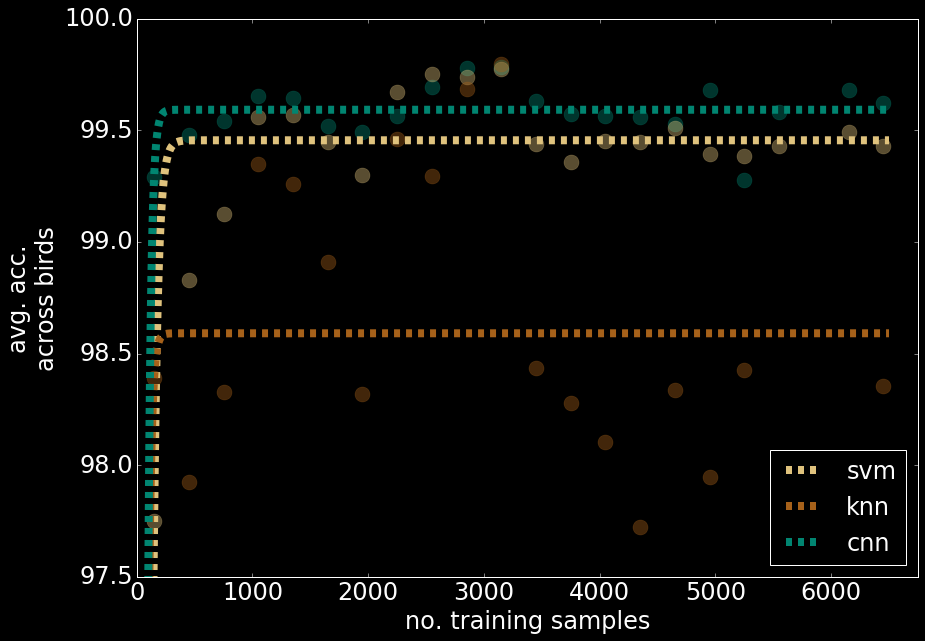

In [12]:
color_dict = {'knn': '#a6611a',
     'svm': '#dfc27d',
     'linear svm': '#80cdc1',
     'cnn': '#018571'}

plotdict = {'knn_test_avg_acc': ('--','knn'),
            'svm_Tach_test_avg_acc': ('--', 'svm'),
            'flatwindow_avg_acc': ('--', 'cnn')}

#plot lin-SVM, SVM-RBF, and k-NN all together on same graph
fig = plt.figure()
plt.style.use('dark_background')
fig.set_size_inches(14,10)

plt.plot(train_size_bin_centers,
        nanmeds['flatwindow_avg_acc'].T,
        '.',alpha=0.4,color=color_dict['cnn'],markersize=30)
plt.plot(train_size_bin_centers,
        nanmeds['svm_Tach_test_avg_acc'].T,
        '.',alpha=0.4,color=color_dict['svm'],markersize=30)
plt.plot(train_size_bin_centers,
        nanmeds['knn_test_avg_acc'].T,
        '.',alpha=0.4,color=color_dict['knn'],markersize=30)

plt.ylim([97,100])

for model in fitlines:
    plt.plot(xx,
             fitlines[model],
             plotdict[model][0],
            label=plotdict[model][1],
            linewidth=8,
            color=color_dict[plotdict[model][1]])
plt.xlim([0,6750])
plt.ylim([97.5,100])
plt.legend(fontsize=24,loc='lower right')
plt.xlabel('no. training samples', fontsize = 24)
plt.ylabel('avg. acc.\nacross birds', fontsize = 24)
plt.tick_params(axis='both', which='major', labelsize=24)
plt.savefig('group_analysis.png', bbox_inches='tight')

### Plot previous results using same figure style

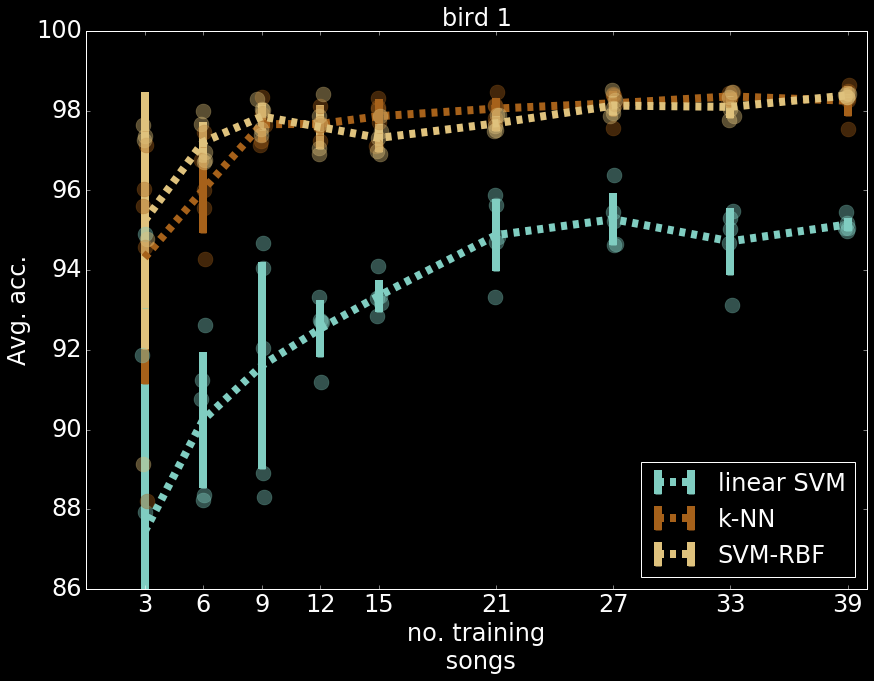

In [16]:
#plot lin-SVM, SVM-RBF, and k-NN all together on same graph
fig = plt.figure()
plt.style.use('dark_background')
fig.set_size_inches(14,10)
results_key = 'gr41rd51'
    
results = results_dict[results_key]

#linsvm
plt.errorbar(NUM_SONGS_TO_TEST,
             results['linsvm_test_avg_acc_mn'],
             yerr=results['linsvm_test_avg_acc_std'],
             fmt='--',label='linear SVM',linewidth=8,
            color=color_dict['linear svm'])
linsvm_avg_acc = np.asarray(results['linsvm_test_avg_acc'])
for ind,x_tick in enumerate(NUM_SONGS_TO_TEST):
    y = linsvm_avg_acc[:,ind]
    x = np.random.normal(x_tick,0.08, size=len(y))
    plt.plot(x, y, '.', alpha=0.4, markersize=30, color=color_dict['linear svm'])  

#knn
plt.errorbar(NUM_SONGS_TO_TEST,
             results['knn_test_avg_acc_mn'],
             yerr=results['knn_test_avg_acc_std'],
             fmt='--',label='k-NN',linewidth=8,
             color=color_dict['knn'])        
knn_avg_acc = np.asarray(results['knn_test_avg_acc'])
for ind,x_tick in enumerate(NUM_SONGS_TO_TEST):
    y = knn_avg_acc[:,ind]
    x = np.random.normal(x_tick,0.08, size=len(y))
    plt.plot(x, y, '.', alpha=0.4, markersize=30, color=color_dict['knn'])

#svm-rbf
plt.errorbar(NUM_SONGS_TO_TEST,
             results['svm_Tach_test_avg_acc_mn'],
             yerr=results['svm_Tach_test_avg_acc_std'],
             fmt='--',label='SVM-RBF',linewidth=8,
             color=color_dict['svm'])
svm_Tach_avg_acc = np.asarray(results['svm_Tach_test_avg_acc'])
for ind,x_tick in enumerate(NUM_SONGS_TO_TEST):
    y = svm_Tach_avg_acc[:,ind]
    x = np.random.normal(x_tick,0.08, size=len(y))
    plt.plot(x, y, '.', alpha=0.4, markersize=30, color=color_dict['svm'])

plt.title('bird 1',fontsize=24)
plt.ylim((86,100))
plt.xticks(NUM_SONGS_TO_TEST)
plt.xlabel('no. training\n songs', fontsize=24)
plt.ylabel('Avg. acc.', fontsize=24)
plt.legend(loc=4, fontsize=24)
plt.savefig('all_algos.png', bbox_inches='tight')
plt.tick_params(axis='both', which='major', labelsize=24)
plt.savefig('bird1_linsvm_knn_svmrbf.png', bbox_inches='tight')

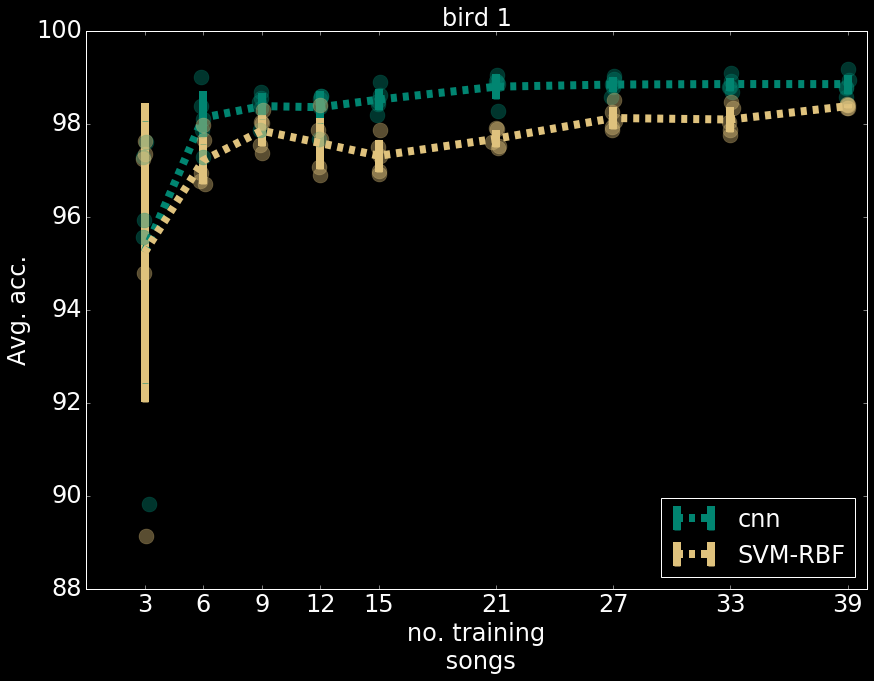

In [15]:
#plot lin-SVM, SVM-RBF, and k-NN all together on same graph
fig = plt.figure()
plt.style.use('dark_background')
fig.set_size_inches(14,10)
ax=[]
results_key = 'gr41rd51'
    
results = results_dict[results_key]

#cnn
plt.errorbar(NUM_SONGS_TO_TEST,
             results['flatwindow_avg_acc_mn'],
             yerr=results['flatwindow_avg_acc_std'],
             fmt='--',label='cnn',linewidth=8,
             color=color_dict['cnn'])        
knn_avg_acc = np.asarray(results['flatwindow_avg_acc'])
for ind,x_tick in enumerate(NUM_SONGS_TO_TEST):
    y = knn_avg_acc[:,ind]
    x = np.random.normal(x_tick,0.08, size=len(y))
    plt.plot(x, y, '.', alpha=0.4, markersize=30, color=color_dict['cnn'])

#svm-rbf
plt.errorbar(NUM_SONGS_TO_TEST,
             results['svm_Tach_test_avg_acc_mn'],
             yerr=results['svm_Tach_test_avg_acc_std'],
             fmt='--',label='SVM-RBF',linewidth=8,
             color=color_dict['svm'])
svm_Tach_avg_acc = np.asarray(results['svm_Tach_test_avg_acc'])
for ind,x_tick in enumerate(NUM_SONGS_TO_TEST):
    y = svm_Tach_avg_acc[:,ind]
    x = np.random.normal(x_tick,0.08, size=len(y))
    plt.plot(x, y, '.', alpha=0.4, markersize=30, color=color_dict['svm'])

plt.title('bird 1',fontsize=24)
plt.ylim((88,100))
plt.xticks(NUM_SONGS_TO_TEST)
plt.xlabel('no. training\n songs', fontsize=24)
plt.ylabel('Avg. acc.', fontsize=24)
plt.legend(loc=4, fontsize=24)
plt.savefig('all_algos.png', bbox_inches='tight')
plt.tick_params(axis='both', which='major', labelsize=24)
plt.savefig('bird1_svmrbf_cnn.png', bbox_inches='tight')